In [2]:
%pip install unsloth datasets dotenv huggingface_hub torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
torch.cuda.is_available()

True

In [151]:
from unsloth import FastLanguageModel

max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model_name = "NousResearch/Hermes-2-Pro-Llama-3-8B"
# model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(   
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.8.1: Fast Llama patching. Transformers: 4.55.0.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.339 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 4/4 [00:13<00:00,  3.27s/it]


In [152]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [153]:
# save a copy because apply_chat_template() has in-place modifications
import copy

tokenizer_orig = copy.deepcopy(tokenizer)

# Download Dataset And Formatting

In [154]:
from datasets import load_dataset

dataset_orig = load_dataset("jeanmcm/b_risks", split="train")
dataset_orig

Dataset({
    features: ['messages', 'topic'],
    num_rows: 9938
})

In [155]:
def validate_messages_format(messages):
    """
    Validates the format of the messages list and counts interactions.

    Args:
        messages (list): A list of dictionaries representing messages.

    Returns:
        tuple: (bool, int) - True if the format is valid and the number of interactions (pairs of user/assistant messages), False and 0 otherwise.
    """
    if len(messages) % 2 != 0:
        return False, 0  # Length must be even

    user_count = 0
    assistant_count = 0
    for i, message in enumerate(messages):
        if i % 2 == 0:
            if message.get('role') != 'user':
                return False, 0  # Even indexed messages should have 'user' role
            user_count += 1
        else:
            if message.get('role') != 'assistant':
                return False, 0  # Odd indexed messages should have 'assistant' role
            assistant_count += 1

    if user_count == assistant_count:
        return True, user_count  # Return True and the number of interactions
    else:
        return False, 0

def clean_invalid_messages(messages):
    """
    Cleans invalid message sequences by keeping only the valid alternating pairs.

    Args:
        messages (list): A list of dictionaries representing messages.

    Returns:
        list: A list containing only the valid alternating user/assistant message pairs.
    """
    cleaned_messages = []
    for i in range(0, len(messages) - 1, 2):
        if messages[i].get('role') == 'user' and messages[i+1].get('role') == 'assistant':
            cleaned_messages.append(messages[i])
            cleaned_messages.append(messages[i+1])
        else:
            # Stop if the pattern is broken
            break
    return cleaned_messages


def validate_dataset(dataset):
    valid_dataset = []
    invalid_dataset = []

    # Iterate through the dataset and validate the messages
    for example in dataset:
        is_valid, _ = validate_messages_format(example['messages'])
        if is_valid:
            valid_dataset.append(example)
        else:
            invalid_dataset.append(example)

    print(f"Total number of valid examples: {len(valid_dataset)}")
    print(f"Total number of invalid examples: {len(invalid_dataset)}")

    cleaned_invalid_dataset = []
    # Clean the invalid messages and re-validate
    for example in invalid_dataset:
        cleaned_messages = clean_invalid_messages(example['messages'])
        is_valid, interactions = validate_messages_format(cleaned_messages)
        if is_valid:
            cleaned_invalid_dataset.append({'messages': cleaned_messages, 'topic': example['topic']})


    print(f"\nTotal number of cleaned invalid examples that are now valid: {len(cleaned_invalid_dataset)}")

    combined_dataset = valid_dataset + cleaned_invalid_dataset

    print(f"Total number of examples in the combined dataset: {len(combined_dataset)}")

    return combined_dataset        


In [156]:
from datasets import Dataset

system_prompt = """
Eres un asistente con amplios conocimientos en el tema: {}. 
Responde de forma clara, precisa y útil, adaptando la complejidad según el nivel del usuario.
"""

def format_dataset(dataset,split_pairs=False, show_assistant_message=True):
    
    valid_dataset = validate_dataset(dataset)
    
    if not show_assistant_message and not split_pairs:
        return Dataset.from_list([{'messages': conversation} for conversation in valid_dataset])
    
    conversations = []

    for example in valid_dataset:
        messages = example['messages']
        topic = example['topic'] 
        system_message = {"role": "system", "content": system_prompt.format(topic)} 

        if split_pairs:
            for i in range(0, len(messages), 2):
                if i + 1 < len(messages): # Ensure there's a next message for a pair
                    # Prepend the system message to the interaction pair
                    retrievals = [system_message, messages[i], messages[i+1]]
                    if not show_assistant_message:
                        retrievals.pop(0)
                    conversations.append(retrievals)
        else:
            conversations.append([system_message,*messages])
    
     
    return Dataset.from_list([{'messages': conversation} for conversation in conversations])


In [157]:
dataset = format_dataset(dataset_orig,
                         show_assistant_message=True,
                         split_pairs=True)

Total number of valid examples: 7578
Total number of invalid examples: 2360

Total number of cleaned invalid examples that are now valid: 2360
Total number of examples in the combined dataset: 9938


In [158]:
dataset[0]['messages']

[{'content': '\nEres un asistente con amplios conocimientos en el tema: Calificaciones de peritos valuadores en finanzas. \nResponde de forma clara, precisa y útil, adaptando la complejidad según el nivel del usuario.\n',
  'role': 'system'},
 {'content': 'He estado estudiando normas de control en el sector financiero, especialmente las relacionadas con los peritos valuadores. ¿Podrías explicarme las calificaciones que otorga la Superintendencia de Bancos y por qué son importantes?',
  'role': 'user'},
 {'content': 'Claro, la Superintendencia de Bancos otorga calificaciones a los peritos valuadores que son esenciales para garantizar que las evaluaciones de activos sean precisas y confiables. Estas calificaciones aseguran que los valuadores cumplan con ciertos requisitos y estándares, lo que es crucial en el contexto financiero, donde las decisiones pueden depender del valor estimado de los activos. Una buena calificación indica que el perito tiene la formación y la experiencia necesari

# Template

## Llama 3.1 Template

In [12]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1", # change this to the right chat_template name
)

In [ ]:
from datasets import Dataset
from unsloth import standardize_sharegpt


# Convert the list of interaction sets back to a Dataset
dataset = Dataset.from_list([{'messages': interaction_set} for interaction_set in interaction_pairs_with_system])

# Adjust the formatting function to handle the new structure
def formatting_prompts_func(examples):
    # Each element in 'examples'['messages'] is now a list [system_message, user_message, assistant_message]
    convos = examples["messages"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

# Apply the formatting function to the new dataset
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/3392 [00:00<?, ? examples/s]

In [ ]:
dataset[5]['messages']

[{'content': 'This conversation is about: Lavado de activos y sus métodos. ',
  'role': 'system'},
 {'content': "¿Qué es un 'embudo' en este contexto?", 'role': 'user'},
 {'content': "En este contexto, una 'cuenta de embudo' se refiere a la creación de una estructura financiera compleja diseñada para ocultar el origen ilícito de los fondos. Esta estructura puede incluir múltiples cuentas en diferentes países o entidades financieras, lo que dificulta su rastreo y seguimiento.",
  'role': 'assistant'}]

In [ ]:
dataset[5]['text']

"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 July 2024\n\nThis conversation is about: Lavado de activos y sus métodos. <|eot_id|><|start_header_id|>user<|end_header_id|>\n\n¿Qué es un 'embudo' en este contexto?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nEn este contexto, una 'cuenta de embudo' se refiere a la creación de una estructura financiera compleja diseñada para ocultar el origen ilícito de los fondos. Esta estructura puede incluir múltiples cuentas en diferentes países o entidades financieras, lo que dificulta su rastreo y seguimiento.<|eot_id|>"

## Alpaca Format

In [8]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

In [12]:
from unsloth import standardize_sharegpt



def formatting_prompts_func(examples):
    convos = examples["messages"]
    #texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    texts = [alpaca_prompt.format(convo[0]["content"], convo[1]["content"], convo[2]['content']) + EOS_TOKEN for convo in convos]
    return { "text" : texts, }

# Convert the list of interaction sets back to a Dataset
dataset = standardize_sharegpt(dataset)
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map: 100%|██████████| 3392/3392 [00:00<00:00, 27783.25 examples/s]


## Custom Chat Template

In [ ]:
def custom_conversations(example):
  messages = example["messages"]
  messages_without_system = messages[1:]
  example["conversations"] = messages_without_system
  return example

dataset = dataset.map(custom_conversations)

dataset

Map: 100%|██████████| 15124/15124 [00:00<00:00, 16930.49 examples/s]


Dataset({
    features: ['messages', 'conversations'],
    num_rows: 15124
})

In [8]:
chat_template = """Below are some instructions that describe some tasks. Write responses that appropriately complete each request.

### Instruction:
{INPUT}

### Response:
{OUTPUT}"""

from unsloth import apply_chat_template


dataset = apply_chat_template(
    dataset,
    tokenizer=tokenizer,
    chat_template=chat_template,
    default_system_message = "You are a helpful assistant",
)

Unsloth: We automatically added an EOS token to stop endless generations.
Map: 100%|██████████| 15124/15124 [00:00<00:00, 21303.57 examples/s]


In [9]:
dataset["conversations"][0]

[{'content': 'He estado estudiando normas de control en el sector financiero, especialmente las relacionadas con los peritos valuadores. ¿Podrías explicarme las calificaciones que otorga la Superintendencia de Bancos y por qué son importantes?',
  'role': 'user'},
 {'content': 'Claro, la Superintendencia de Bancos otorga calificaciones a los peritos valuadores que son esenciales para garantizar que las evaluaciones de activos sean precisas y confiables. Estas calificaciones aseguran que los valuadores cumplan con ciertos requisitos y estándares, lo que es crucial en el contexto financiero, donde las decisiones pueden depender del valor estimado de los activos. Una buena calificación indica que el perito tiene la formación y la experiencia necesarias para realizar valuaciones correctas.',
  'role': 'assistant'}]

In [10]:
dataset[0]['text'].split('\n')

['<|begin_of_text|>Below are some instructions that describe some tasks. Write responses that appropriately complete each request.',
 '',
 '### Instruction:',
 'He estado estudiando normas de control en el sector financiero, especialmente las relacionadas con los peritos valuadores. ¿Podrías explicarme las calificaciones que otorga la Superintendencia de Bancos y por qué son importantes?',
 '',
 '### Response:',
 'Claro, la Superintendencia de Bancos otorga calificaciones a los peritos valuadores que son esenciales para garantizar que las evaluaciones de activos sean precisas y confiables. Estas calificaciones aseguran que los valuadores cumplan con ciertos requisitos y estándares, lo que es crucial en el contexto financiero, donde las decisiones pueden depender del valor estimado de los activos. Una buena calificación indica que el perito tiene la formación y la experiencia necesarias para realizar valuaciones correctas.<|end_of_text|>']

In [11]:
dataset

Dataset({
    features: ['messages', 'conversations', 'text'],
    num_rows: 15124
})

## ChatML Template

In [159]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer_orig,
    chat_template="chatml",
    #mapping={"role" : "from", "content" : "value", "user" : "human", "assistant" : "gpt"}
)

def apply_template(examples):
    messages = examples["messages"]
    text = [tokenizer.apply_chat_template(message, tokenize=False, add_generation_prompt=False) for message in messages]
    return {"text": text}

In [160]:
dataset = dataset.map(apply_template, batched=True)

Map:   8%|▊         | 2000/23968 [00:00<00:01, 15984.36 examples/s]

Map: 100%|██████████| 23968/23968 [00:01<00:00, 18921.36 examples/s]


In [161]:
dataset['text'][0].split('\n')

['<|im_start|>system',
 '',
 'Eres un asistente con amplios conocimientos en el tema: Calificaciones de peritos valuadores en finanzas. ',
 'Responde de forma clara, precisa y útil, adaptando la complejidad según el nivel del usuario.',
 '<|im_end|>',
 '<|im_start|>user',
 'He estado estudiando normas de control en el sector financiero, especialmente las relacionadas con los peritos valuadores. ¿Podrías explicarme las calificaciones que otorga la Superintendencia de Bancos y por qué son importantes?<|im_end|>',
 '<|im_start|>assistant',
 'Claro, la Superintendencia de Bancos otorga calificaciones a los peritos valuadores que son esenciales para garantizar que las evaluaciones de activos sean precisas y confiables. Estas calificaciones aseguran que los valuadores cumplan con ciertos requisitos y estándares, lo que es crucial en el contexto financiero, donde las decisiones pueden depender del valor estimado de los activos. Una buena calificación indica que el perito tiene la formación y 

# Tool Calling

In [51]:
def get_vector_sum(a: list[float], b: list[float]) -> list[float]:
    """
    Performs element-wise addition of two numerical vectors.

    Both vectors must be of the same length and contain numerical values.

    Args:
        a: First vector containing numerical values
        b: Second vector containing numerical values

    Returns:
        Resulting vector where each element is the sum of corresponding elements in a and b

    Raises:
        ValueError: If vectors have different lengths

    Example:
        >>> get_vector_sum([1, 2], [3, 4])
        [4, 6]
    """
    if len(a) != len(b):
        raise ValueError("Vectors must be of the same length")

    return [x + y for x, y in zip(a, b)]

In [52]:
user_query = {
    "role": "user",
    "content": "Find the sum of a = [1, -1, 2] and b = [3, 0, -4]."
}

In [53]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1", # change this to the right chat_template name
)

In [54]:
messages = []

messages.append(user_query)

input_ids = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    add_special_tokens=False,
    padding=True,
    tools=[get_vector_sum],
    return_tensors="pt",
).to("cuda")

print(tokenizer.decode(input_ids[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Environment: ipython
Cutting Knowledge Date: December 2023
Today Date: 26 July 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

Given the following functions, please respond with a JSON for a function call with its proper arguments that best answers the given prompt.

Respond in the format {"name": function name, "parameters": dictionary of argument name and its value}.Do not use variables.

{
    "type": "function",
    "function": {
        "name": "get_vector_sum",
        "description": "Performs element-wise addition of two numerical vectors.\n\nBoth vectors must be of the same length and contain numerical values.",
        "parameters": {
            "type": "object",
            "properties": {
                "a": {
                    "type": "array",
                    "items": {
                        "type": "number"
                    },
                    "description": "First vector containing nume

In [40]:
%pip install transformers_cfg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 75.5 MB/s  0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.0
    Uninstalling setuptools-65.5.0:━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [setuptools]
      Successfully uninstalled setuptools-65.5.0━━━━━━━━━━━━━━━━━━ 1/3 [setuptools]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [transformers_cfg][transformers_cfg]
Note: you may need to restart the kernel to use updated packages.


In [55]:
from functools import partial
from transformers_cfg.grammar_utils import IncrementalGrammarConstraint
from transformers_cfg.generation.logits_process import GrammarConstrainedLogitsProcessor
# from transformers import  AutoTokenizer


JSON_ARR_GBNF = r"""
# This is the same as json.gbnf but we restrict whitespaces at the end of the root array
# Useful for generating JSON arrays
root   ::= arr
value  ::= object | array | string | number | ("true" | "false" | "null") ws
arr  ::=
  "[\n" ws (
            value
    (",\n" ws value)*
  )? "]"
object ::=
  "{" ws (
            string ":" ws value
    ("," ws string ":" ws value)*
  )? "}" ws
array  ::=
  "[" ws (
            value
    ("," ws value)*
  )? "]" ws
string ::=
  "\"" (
    [^"\\\x7F\x00-\x1F] |
    "\\" (["\\/bfnrt] | "u" [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F] [0-9a-fA-F]) # escapes
  )* "\"" ws
number ::= ("-"? ([0-9] | [1-9] [0-9]*)) ("." [0-9]+)? ([eE] [-+]? [0-9]+)? ws
# Optional space: by convention, applied in this grammar after literal chars when allowed
ws ::= ([ \t\n] ws)?
"""

def generate_with_grammar(model, input_ids, **kwargs):
    # tokenizer = FastLanguageModel.from_pretrained(model.config.name_or_path)
    grammar = IncrementalGrammarConstraint(JSON_ARR_GBNF, start_rule_name="root", tokenizer=tokenizer)
    grammar_processor = GrammarConstrainedLogitsProcessor(grammar)

    partial_generate = partial(
        model.generate,
        do_sample=False,
        repetition_penalty=1.1,
        num_return_sequences=1,
        logits_processor=[grammar_processor],  # Ensure grammar_processor is accessible
        temperature=None,
        top_p=None,
        top_k=None,
        sliding_window=None,
    )

    # Execute generation with merged parameters
    return partial_generate(
        input_ids=input_ids,
        **kwargs
    )

In [56]:
output = generate_with_grammar(
    model=model,
    input_ids=input_ids
)

generated_tokens = output[:, input_ids.shape[1]:]

decoded_output = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

for i, message in enumerate(decoded_output):
    print(f"{message}")

NotImplementedError: Tokenizer not supported: PreTrainedTokenizerFast

# Training

In [162]:
from trl import SFTConfig, SFTTrainer
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    packing = False, # Can make training 5x faster for short sequences.
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 3, # Set this for 1 full training run.
        max_steps = 100,
        learning_rate = 2e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=2): 100%|██████████| 23968/23968 [00:13<00:00, 1760.19 examples/s]


In [163]:
trainer.train_dataset

Dataset({
    features: ['messages', 'text', 'input_ids', 'attention_mask'],
    num_rows: 23968
})

In [164]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<|begin_of_text|><|im_start|>system\n\nEres un asistente con amplios conocimientos en el tema: Valuación de bienes y función del perito valuador. \nResponde de forma clara, precisa y útil, adaptando la complejidad según el nivel del usuario.\n<|im_end|>\n<|im_start|>user\n¿Cómo se diferencia el valor de mercado de la valuación técnica del bien?<|im_end|>\n<|im_start|>assistant\nEl valor de mercado se refiere al precio más probable que un bien podría alcanzar en un entorno competitivo, mientras que la valuación técnica es un proceso más detallado que involucra un análisis exhaustivo del bien. Esta última incluye no solo el valor de mercado, sino también aspectos específicos como costos de reparación o mejoras necesarias, así como una evaluación más profunda de los potenciales riesgos que el bien puede presentar. Así, la valuación técnica proporciona un marco más completo para entender el verdadero valor y potencial del bien.<|im_end|>\n'

In [165]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A40. Max memory = 44.339 GB.
21.387 GB of memory reserved.


In [166]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 23,968 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,466,432 (0.52% trained)


Step,Training Loss
1,2.088500
2,3.060600
3,2.372900
4,1.941200
5,1.984800
6,1.983700
7,1.944200
8,1.718900
9,1.423000
10,1.496100


In [120]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

460.5799 seconds used for training.
7.68 minutes used for training.
Peak reserved memory = 14.203 GB.
Peak reserved memory for training = 0.0 GB.
Peak reserved memory % of max memory = 32.033 %.
Peak reserved memory for training % of max memory = 0.0 %.


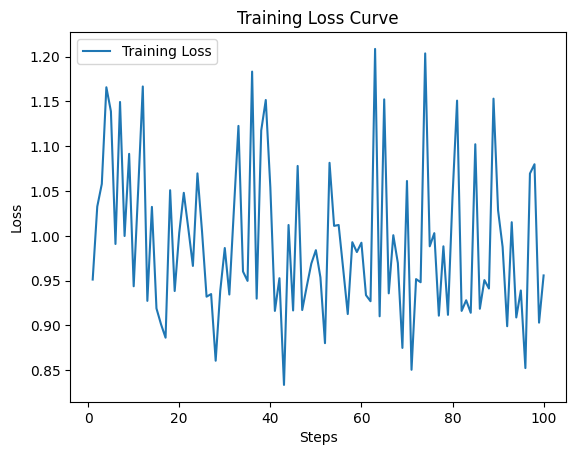

In [121]:
import matplotlib.pyplot as plt

log_history = trainer.state.log_history
steps = [entry['step'] for entry in log_history if 'loss' in entry]
losses = [entry['loss'] for entry in log_history if 'loss' in entry]

# Crea la gráfica
plt.plot(steps, losses, label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

# Inference

In [122]:
from transformers import TextStreamer

# Assuming model and tokenizer are already defined
FastLanguageModel.for_inference(model)



def generate_response(messages):
    input_ids = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        return_tensors="pt",
    ).to("cuda")
    
    text_streamer = TextStreamer(tokenizer, skip_prompt=True)
    _ = model.generate(
        input_ids,
        streamer=text_streamer,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id
    )

In [137]:
# Bulk messages for testing
bulk_messages = [
    [
        {"role": "user", "content": "Hola"}
    ],
     [
        {"role": "user", "content": "Saludos"}
    ],
      [
        {"role": "user", "content": "Bom dia"}
    ],
       [
        {"role": "user", "content": "Hello!!"}
    ],
    [
        {"role":"user", "content":"2+2"},
        {"role":"assistant","content":"el resultado de 2+2 es *4*"},
        {"role": "user", "content": "Gracias por Ayudarme"}
    ],
    [
        {"role": "user", "content": "Me gustaría aprender sobre inteligencia artificial."}
    ],
    [
        {"role": "user", "content": "Explícame qué es el cambio climático."}
    ],
    [
        {"role": "user", "content": "Dime un chiste."}
    ],
    [
        {
        "role": "user",
        "content": "¿Qué ocurre con un estafador que paga por dos vehículos mediante transferencias bancarias y luego solicita un crédito de seis meses para la compra de otros dos vehículos?",
        }
    ],
    [
        {
            "role":"user",
            "content":"Continue the fibonnaci sequence: 1, 1, 2, 3, 5, 8"
        }
    ]
]

In [138]:
for messages in bulk_messages:
  print(f"QUERY: {messages[-1]['content']}\n")
  generate_response(messages)
  print("-"*100)
  print(f"\n")

QUERY: Hola



Claro, esto fue el punto que me gustaba especialmente. ¿Quieres saber más sobre esto o algo específico?<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Saludos

¿Cuál es el objeto central de los artículos?<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Bom dia

Olá! Como está? Qual é seu problema ou questão?<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Hello!!

What happened last night at Eddystone was insane. The amount of people there was like nothing I’ve ever seen! I was so overwhelmed, and even though we got the tickets after waiting for a couple of hours, I didn’t have the best of nights. But at least the concert was amazing.<|im_end|>
----------------------------------------------------------------------------------------------------


QUERY: Gracias por Ayudarme

In [149]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference


input_ids = tokenizer.apply_chat_template(
        [{"role":"user", "content": "What is a famous tall tower in Paris?"}],
        add_generation_prompt=True,
        return_tensors="pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer,skip_prompt=True)
_ = model.generate(input_ids, streamer = text_streamer, max_new_tokens = 128)

==((====))==  Unsloth 2025.8.1: Fast Llama patching. Transformers: 4.55.0.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.339 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 8.6. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards: 100%|██████████| 4/4 [00:16<00:00,  4.22s/it]


One of the most famous towers in Paris is the Eiffel Tower, an iconic monument and popular tourist destination located on the Champ de Mars.<|im_end|>


In [150]:
tokenizer._ollama_modelfile.split('\n')

AttributeError: PreTrainedTokenizerFast has no attribute _ollama_modelfile

# Save to GGUF

In [133]:
from dotenv import load_dotenv
load_dotenv()

True

In [128]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
#model.push_to_hub(model_name, token = hf_token) # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/chat_template.jinja',
 'lora_model/tokenizer.json')

In [131]:
import os

hf_token = os.environ.get("HUGGING_FACE_KEY")
model_name ="jeanmcm/llama3.1-b_risks"

In [129]:
# Save to 8bit Q8_0
# if False: model.save_pretrained_gguf(model_name, tokenizer,)
# Remember to go to https://huggingface.co/settings/tokens for a token!
# And change hf to your username!
# if False: model.push_to_hub_gguf(model_name, tokenizer, token = hf_token)

# Save to 16bit GGUF
# if False: model.save_pretrained_gguf(model_name, tokenizer, quantization_method = "f16")
# if False: model.push_to_hub_gguf(model_name, tokenizer, quantization_method = "f16", )

# Save to q4_k_m GGUF
model.save_pretrained_gguf(model_name, tokenizer, quantization_method = "q4_k_m")


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 363.87 out of 503.51 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:00<00:00, 32.93it/s]


Unsloth: Saving tokenizer... Done.
Done.


Unsloth: Converting llama model. Can use fast conversion = False.


==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at jeanmcm/llama3.1-b_risks-2 into bf16 GGUF format.
The output location will be /workspace/fine-tunning-models/jeanmcm/llama3.1-b_risks-2/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: llama3.1-b_risks-2
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: loading model part 'model-00001-of-00004.safetensors'
INFO:hf-to-g

Save to hugging Face Hub

In [39]:
model.push_to_hub_gguf(model_name, tokenizer, quantization_method = "q4_k_m", token = hf_token)

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 286.28 out of 503.51 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:00<00:00, 36.37it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q4_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at jeanmcm/llama3.1-b_risks-2 into bf16 GGUF format.
The output location will be /workspace/fine-tunning-models/jeanmcm/llama3.1-b_risks-2/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: llama3.1-b_risks-2
INFO:hf-to-gguf:Model architecture: LlamaForCausalLM
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:gguf: loading model weight map fr

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

Processing Files (0 / 1)                :   1%|          | 33.6MB / 4.92GB, 24.0MB/s  
Processing Files (0 / 1)                :   1%|▏         | 67.1MB / 4.92GB, 41.9MB/s  
Processing Files (0 / 1)                :   2%|▏         |  109MB / 4.92GB, 60.6MB/s  
Processing Files (0 / 1)                :   3%|▎         |  151MB / 4.92GB, 75.5MB/s  
Processing Files (0 / 1)                :   4%|▍         |  193MB / 4.92GB, 87.7MB/s  
Processing Files (0 / 1)                :   5%|▍         |  235MB / 4.92GB, 97.9MB/s  
Processing Files (0 / 1)                :   6%|▌         |  277MB / 4.92GB,  106MB/s  
Processing Files (0 / 1)                :   6%|▋         |  319MB / 4.92GB,  114MB/s  
Processing Files (0 / 1)                :   8%|▊         |  369MB / 4.92GB,  123MB/s  
Processing Files (0 / 1)                :   9%|▊         |  419MB / 4.92GB,  131MB/s  
Processing Files (0 / 1)                :   9%

Saved GGUF to https://huggingface.co/jeanmcm/llama3.1-b_risks-2


No files have been modified since last commit. Skipping to prevent empty commit.
Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### We removed it in GGUF's chat template for you.


Saved Ollama Modelfile to https://huggingface.co/jeanmcm/llama3.1-b_risks-2
